In [14]:
import io
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras

# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import Sequential

from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.layers import Dense, Input, Lambda, LSTM

In [15]:
#function to plot a series
def plot_series(x, y, type_=None, ylabel=None, format="-", start=None, end=None, label=None, multi_plot=True):
    if not multi_plot:
        plt.figure(figsize=(20, 10))
    plt.plot(x[start:end], y[start:end], format, label=label)
    plt.xlabel("Date", labelpad=50, fontsize=14)
    plt.ylabel(f"{ylabel} Volume", labelpad=50, fontsize=14)
    if label:
        plt.legend(fontsize=14)
    plt.grid(True, which='both')
    x_ticks = x.to_list()
    x_max = max(x_ticks)
    x_ticks = x_ticks[::round(len(x_ticks)/10)]
    x_ticks.append(x_max)
    plt.xticks(x_ticks, rotation = 30)
    if not multi_plot:
        plt.savefig(f'../plots/{ylabel.lower()}/{ylabel.lower()}_{type_}_time_series.png')
        plt.show()


#clear session 
def refresh():
    keras.backend.clear_session()
    tf.random.set_seed(42)
    np.random.seed(42)

class ResetStatesCallback(Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

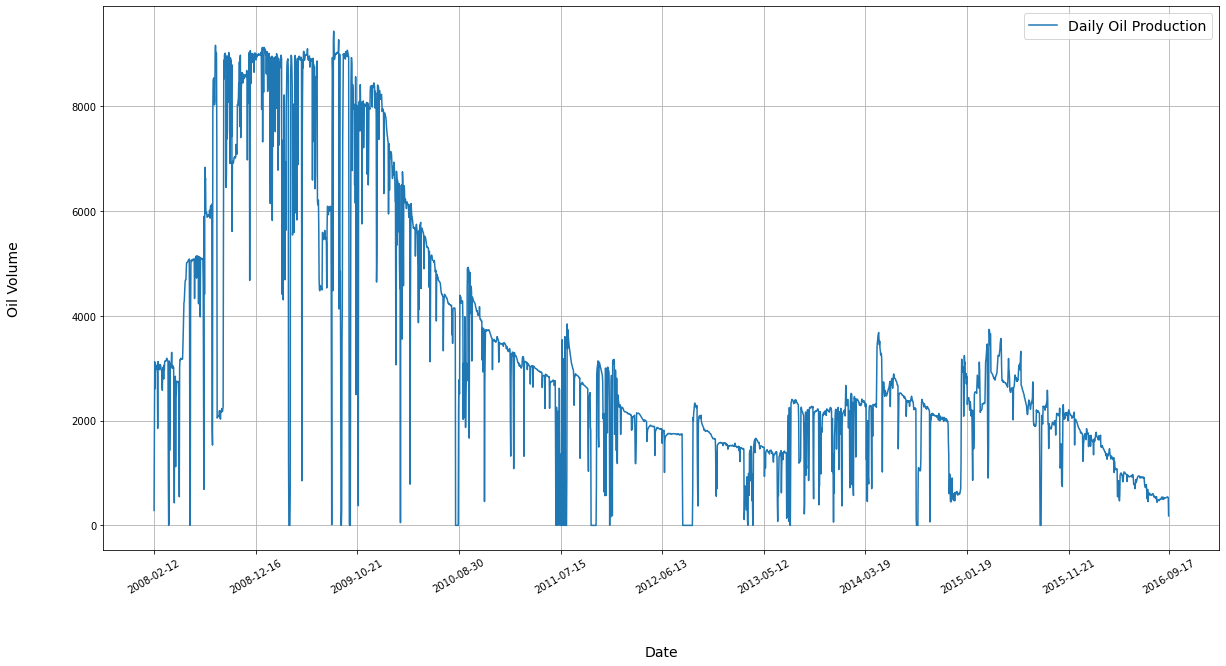

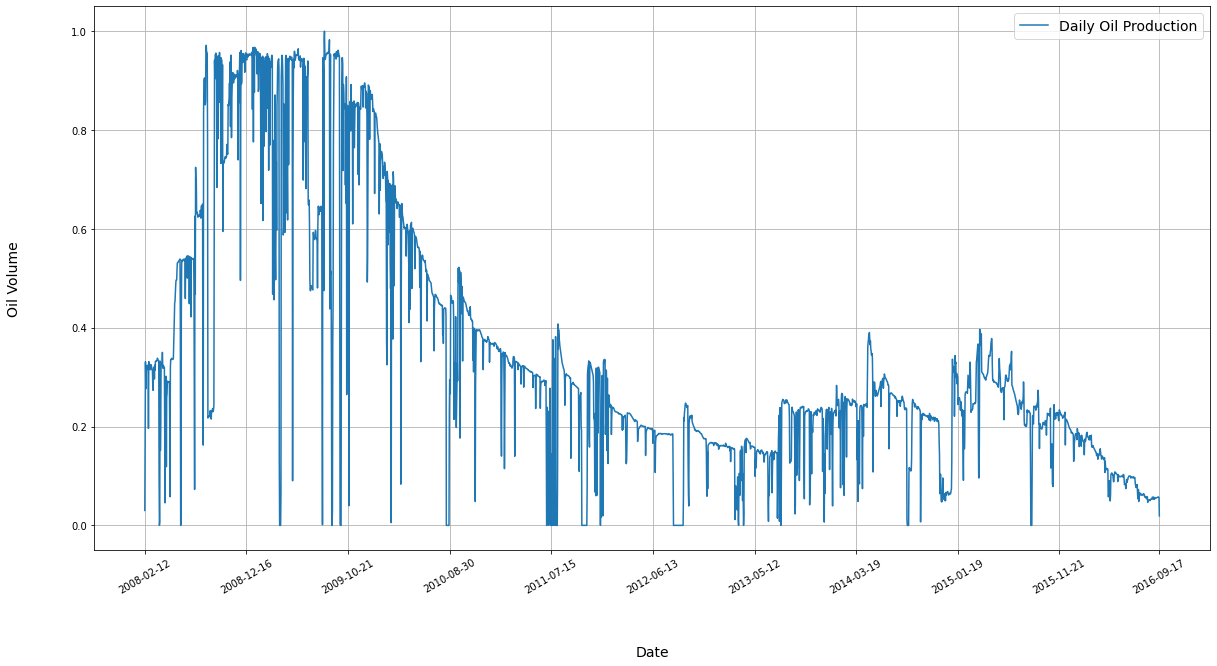

(2140,) (2140,) (916,) (916,)


In [16]:
df = pd.read_csv("../datasets/consolidated_data/oil_data.csv", index_col="DATEPRD")
date = df.index

oil_data = df.BORE_OIL_VOL.to_numpy()
plot_series(date, oil_data, "unscaled", "Oil", label="Daily Oil Production", multi_plot=False)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled, index=df.index, columns=df.columns)

scaled_oil_data = scaled_df.BORE_OIL_VOL.to_numpy()
plot_series(date, scaled_oil_data, "scaled", "Oil", label="Daily Oil Production", multi_plot=False)


#split the time series into training and validation sets
split_date = 2140

date_train = date[:split_date]
date_valid = date[split_date:]

oil_train = scaled_oil_data[:split_date]
oil_valid = scaled_oil_data[split_date:]

print(date_train.shape, oil_train.shape, date_valid.shape, oil_valid.shape)

In [17]:
def window_dataset(series, window_size, batch_size=30, shuffle_buffer=100):
    
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(2)
    
    return dataset


def sequential_window_dataset(series, window_size):
    
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=window_size, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[1:]))
    
    return dataset.batch(1).prefetch(1)


def forecast_model(model, series, window_size):
    
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(30).prefetch(2)
    
    forecast = model.predict(dataset)
    
    return forecast


def plot_model_forecast (model, file_name, label, window_size=None):
    if label=="LSTM":
        forecast = model.predict(scaled_oil_data[np.newaxis, :, np.newaxis])[0, split_date - 1:-1, 0]
    else:
        forecast = forecast_model(model, scaled_oil_data[split_date - window_size:-1], window_size)[:, 0]

    plt.figure(figsize=(20, 10))

    plot_series(date_valid, oil_valid, ylabel="Oil", label="Actual")
    plot_series(date_valid, forecast, ylabel="Oil", label=f"{label} Model")

    plt.savefig(f'../plots/oil/{file_name}.png')
    plt.show()

    mae = keras.metrics.mean_absolute_error(oil_valid, forecast).numpy()
    mse = keras.metrics.mean_squared_error(oil_valid, forecast).numpy()
    rmse = math.sqrt(mse)

    print(f'mae = {mae}, \nmse = {mse}, \nrmse = {rmse}')

In [18]:
def model_linear(callbacks, window_size=30, epochs=500, learning_rate=1e-3, file_name=None):
    refresh()

    oil_train_set = window_dataset(oil_train, window_size)
    oil_valid_set = window_dataset(oil_valid, window_size)

    model = Sequential( [ Dense(1, input_shape=[window_size]) ] )

    optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

    model.compile(loss=keras.losses.Huber(),
                optimizer=optimizer,
                metrics=["mae"])

    history = model.fit(
        
        oil_train_set,
        epochs=epochs,
        validation_data=oil_valid_set,
        callbacks=callbacks

    )

    if file_name:
        model.save(f'linear/{file_name}.h5')

    return history, model

def model_ffnn(callbacks, window_size=30, units=10, learning_rate=1e-3, epochs=500, file_name="None"):
    refresh()

    oil_train_set = window_dataset(oil_train, window_size)
    oil_valid_set = window_dataset(oil_valid, window_size)

    model = Sequential([
                Dense(units, activation="relu", input_shape=[window_size]),
                Dense(units, activation="relu"),
                Dense(1)
            ])

    optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

    model.compile(loss=keras.losses.Huber(),
                optimizer=optimizer,
                metrics=["mae"])


    history = model.fit(oil_train_set,
            epochs=epochs,
            validation_data=oil_valid_set,
            callbacks=callbacks)

    if file_name:
        model.save(f'ffnn/{file_name}.h5')

    return history, model
    
def model_lstm(callbacks, window_size=30, units=10, learning_rate=1e-3, epochs=500, file_name="None"):
    refresh()

    oil_train_set = sequential_window_dataset(oil_train, window_size)
    oil_valid_set = sequential_window_dataset(oil_valid, window_size)

    model = Sequential([
    
        LSTM(units, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]),
        LSTM(units, return_sequences=True, stateful=True),
        Dense(1)
    
        ])

    optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

    model.compile(loss=keras.losses.Huber(),
                optimizer=optimizer,
                metrics=["mae"])


    history = model.fit(oil_train_set,
            epochs=epochs,
            validation_data=oil_valid_set,
            callbacks=callbacks)

    if file_name:
        model.save(f'lstm/{file_name}.h5')

    return history, model

# Linear Model

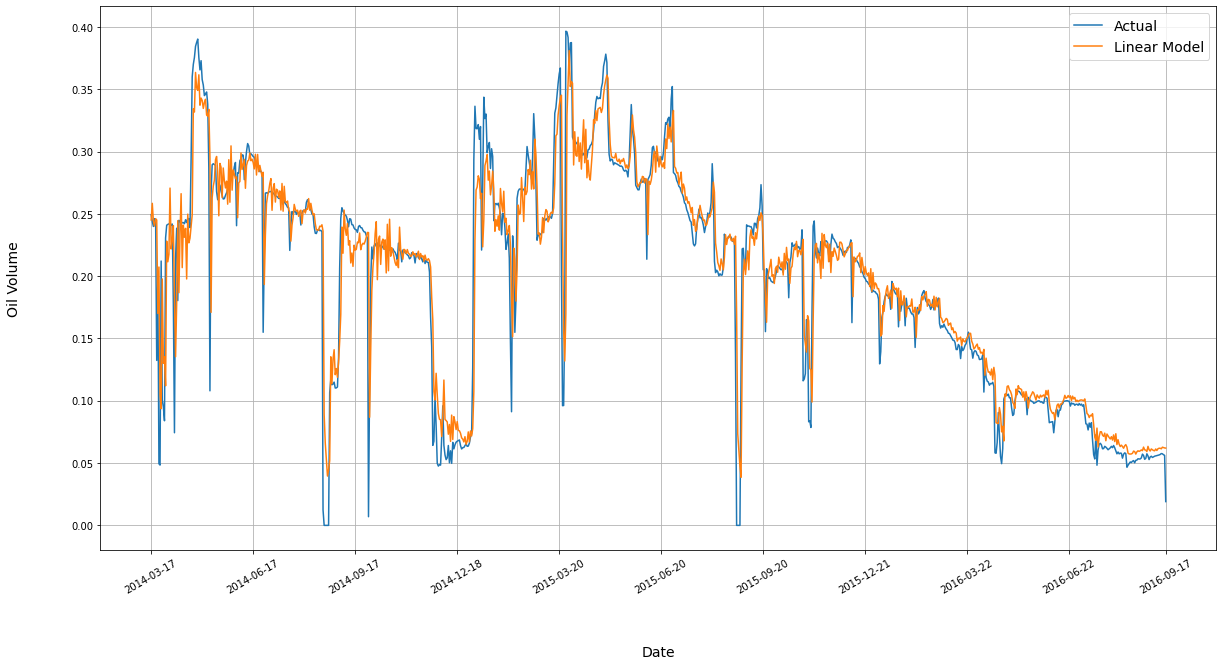

mae = 0.01636890321969986, 
mse = 0.0009179107728414237, 
rmse = 0.030297042311773995
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 31        
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________
[<tf.Variable 'dense/kernel:0' shape=(30, 1) dtype=float32, numpy=
array([[ 0.01023294],
       [ 0.03149624],
       [-0.08059137],
       [ 0.02751068],
       [ 0.01055475],
       [ 0.03290596],
       [ 0.02562249],
       [ 0.04276284],
       [-0.00134598],
       [-0.01908923],
       [ 0.08500396],
       [-0.15233009],
       [ 0.14138289],
       [-0.13368686],
       [ 0.11793065],
       [-0.03782655],
       [ 0.0205937 ],
       [ 0.00385739],
       [-0.05849741],
       [ 0.09042342],
       [-0.00590286],
       [-0.07701647],
       [ 0.160252

In [14]:

# lr_schedule = LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 30))
# history, model = linear_model(callbacks=[lr_schedule])

# plt.semilogx(history.history["lr"], history.history["loss"])
# plt.axis([5e-5, 5e-1, 0, 0.3])
# plt.show()

# max(history.history["loss"])

# early_stopping = EarlyStopping(patience=10)
# linear_history, linear_model = model_linear(callbacks=[early_stopping], file_name="linear_oil_model")
linear_model = keras.models.load_model("linear/linear_oil_model.h5")

plot_model_forecast(linear_model, 30, "oil_linear_forecast", "Linear")
linear_model.summary()
print(linear_model.trainable_variables)

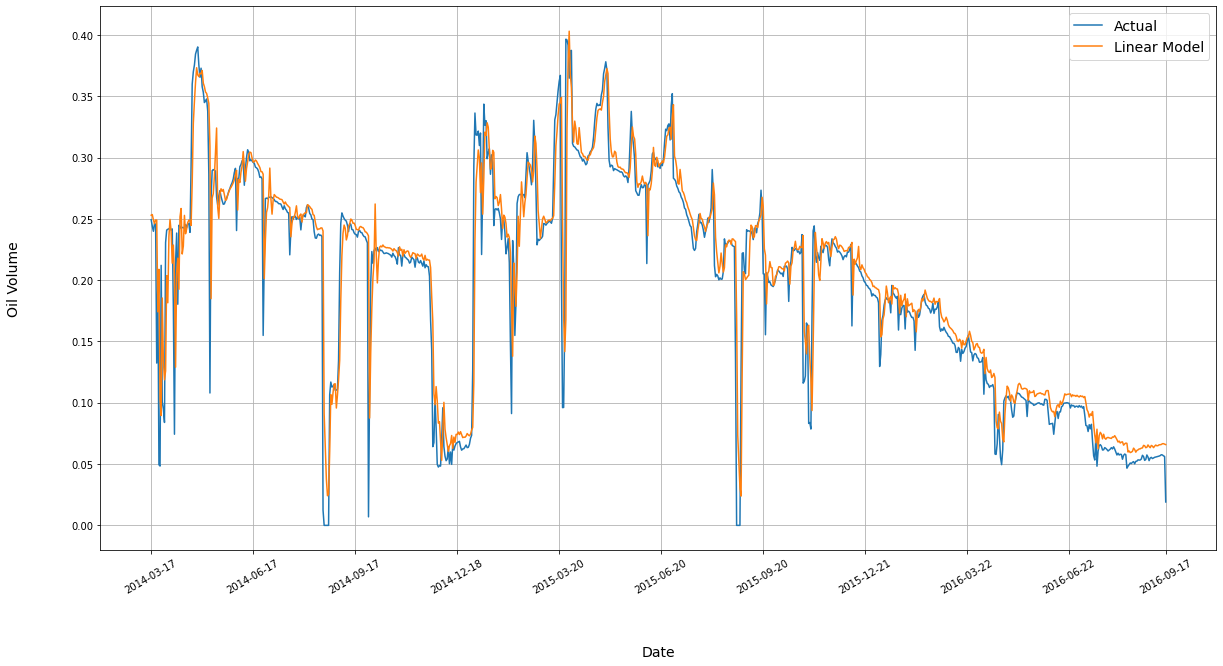

mae = 0.015755433589220047, 
mse = 0.000898677681107074, 
rmse = 0.029977953250798727
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
[<tf.Variable 'dense/kernel:0' shape=(8, 1) dtype=float32, numpy=
array([[ 0.09907673],
       [ 0.11581515],
       [-0.1551119 ],
       [-0.00843579],
       [ 0.05434345],
       [ 0.11816936],
       [ 0.08138622],
       [ 0.66289634]], dtype=float32)>, <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([0.01128497], dtype=float32)>]


In [8]:
# early_stopping = EarlyStopping(patience=10)
# linear_history, linear_model = model_linear(callbacks=[early_stopping], window_size=8, file_name="optimized_linear_model")
linear_model = keras.models.load_model("linear/optimized_linear_model.h5")

plot_model_forecast(linear_model, 8, "oil_linear_optimized_forecast", "Linear")
linear_model.summary()
print(linear_model.trainable_variables)

#  FF-NN

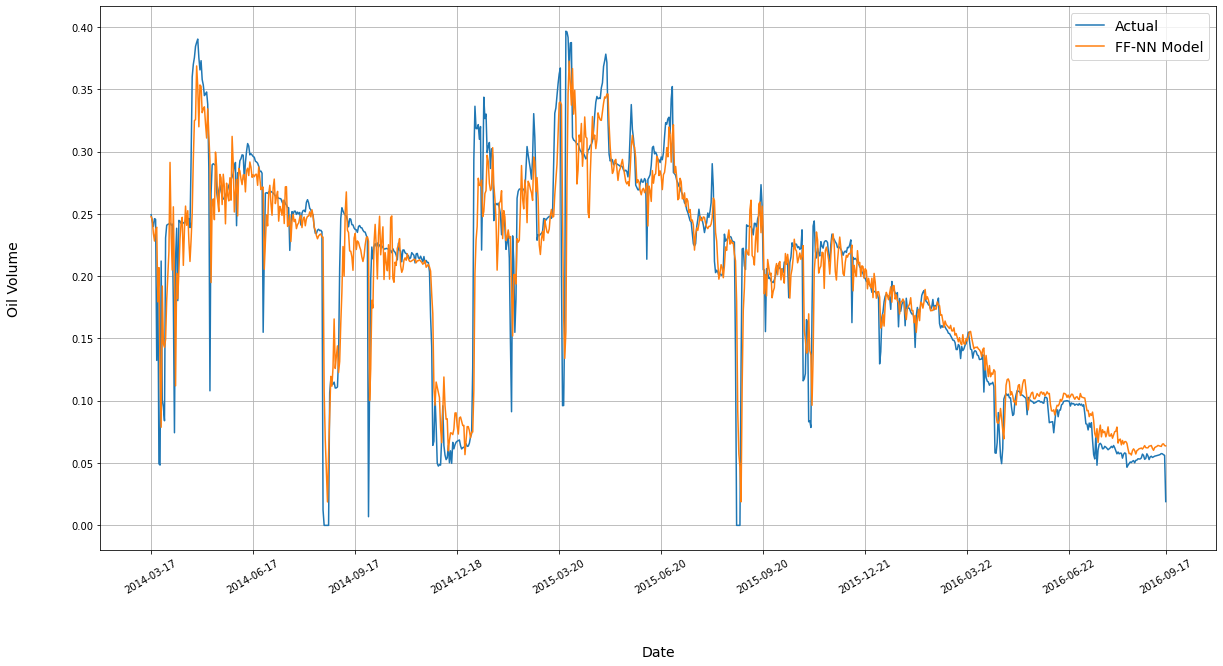

mae = 0.01900336891412735, 
mse = 0.0010764605831354856, 
rmse = 0.032809458744933385
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                310       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 431
Trainable params: 431
Non-trainable params: 0
_________________________________________________________________
[<tf.Variable 'dense/kernel:0' shape=(30, 10) dtype=float32, numpy=
array([[ 0.20595807,  0.11447667, -0.37471336, -0.13015972, -0.00883457,
        -0.05609543, -0.3234913 , -0.3707634 , -0.15478274, -0.0202557 ],
       [ 0.1331887 , -0.31488374,  0.33438036, -0.24735996,  0.1345936 ,
         0.040

In [17]:

# lr_schedule = LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 20))
# history, model = model_ffnn(callbacks=[lr_schedule])

# plt.semilogx(history.history["lr"], history.history["loss"])
# plt.axis([1e-5, 1, 0, 0.12])
# plt.show()

# max(history.history["loss"])

# early_stopping = EarlyStopping(patience=10)
# ffnn_history, ffnn_model = model_ffnn(callbacks=[early_stopping], file_name="ffnn_oil_model")
ffnn_model = keras.models.load_model("ffnn/ffnn_oil_model.h5")

plot_model_forecast(ffnn_model, 30, "oil_ffnn_forecast", label="FF-NN")
ffnn_model.summary()
print(ffnn_model.trainable_variables)

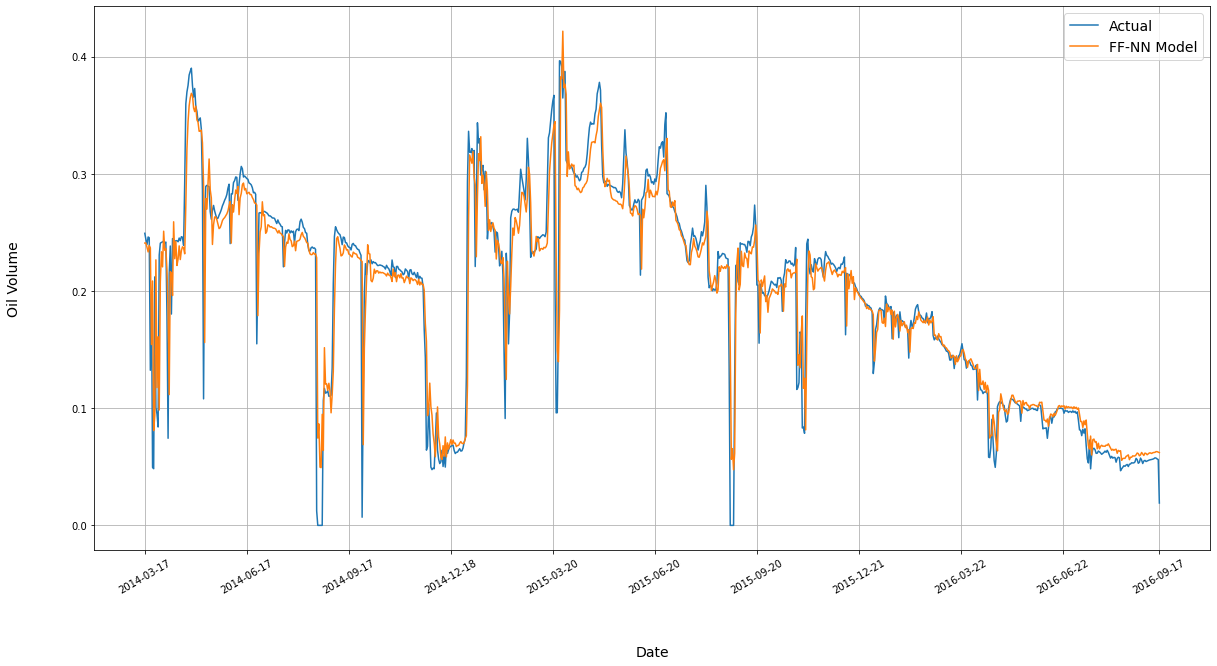

mae = 0.015496636740863323, 
mse = 0.0008438794757239521, 
rmse = 0.029049603710273778
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 29)                261       
_________________________________________________________________
dense_1 (Dense)              (None, 29)                870       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 30        
Total params: 1,161
Trainable params: 1,161
Non-trainable params: 0
_________________________________________________________________
[<tf.Variable 'dense/kernel:0' shape=(8, 29) dtype=float32, numpy=
array([[ 1.99729756e-01,  9.91337225e-02, -3.77601087e-01,
        -1.27871633e-01,  1.28606940e-02, -1.17589846e-01,
        -3.65809351e-01, -3.85482281e-01, -1.84631094e-01,
         2.59078748e-04,  1.52532414e-01, -3.43728542

In [21]:
# early_stopping = EarlyStopping(patience=10)
# ffnn_history, ffnn_model = model_ffnn(callbacks=[early_stopping], window_size=8, units=29, file_name="optimized_ffnn_model")
ffnn_model = keras.models.load_model("ffnn/optimized_ffnn_model.h5")

plot_model_forecast(ffnn_model, 8, "oil_ffnn_optimized_forecast", label="FF-NN")
ffnn_model.summary()
print(ffnn_model.trainable_variables)

# RNN Model - LSTM

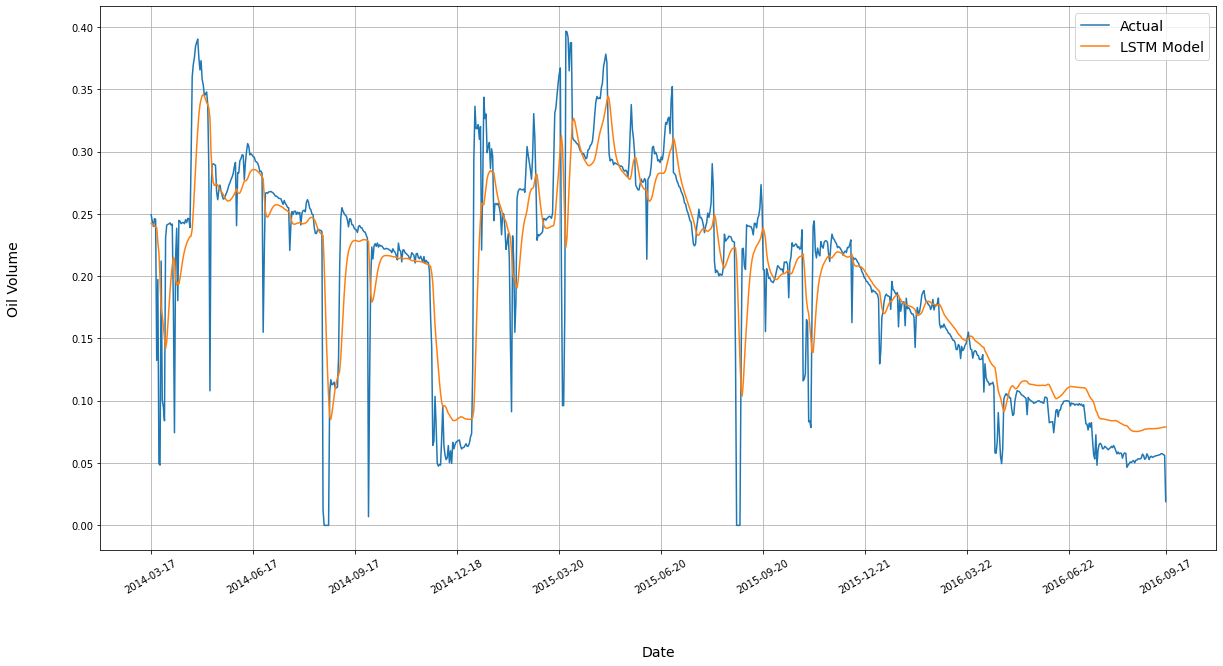

mae = 0.024986369535326958, 
mse = 0.00174854532815516, 
rmse = 0.041815611058014686
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, None, 10)             480       
_________________________________________________________________
lstm_1 (LSTM)                (1, None, 10)             840       
_________________________________________________________________
dense (Dense)                (1, None, 1)              11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________
[<tf.Variable 'lstm/lstm_cell_6/kernel:0' shape=(1, 40) dtype=float32, numpy=
array([[ 0.12715334, -0.03530806, -0.11401649, -0.02173844, -0.33366272,
         0.15984134,  0.23008706,  0.30890104, -0.17613973, -0.21244234,
        -0.14184295,  0.18445289, -0.2899859 ,  0.03219714,  0.06786441,
  

In [11]:

# learning_rate_schedule = LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 20))
# reset_states = ResetStatesCallback()
# lstm_history, lstm_model = model_lstm(callbacks=[learning_rate_schedule, reset_states])

# plt.semilogx(lstm_history.history["lr"], lstm_history.history["loss"])
# plt.axis([1e-5, 10, 0.009, 0.12])
# plt.show()

# max(lstm_history.history["lr"])

# reset_states = ResetStatesCallback()
# model_checkpoint = ModelCheckpoint("lstm/LSTM_oil_checkpoint.h5", save_best_only=True)
# early_stopping = EarlyStopping(patience=50)
# lstm_history, lstm_model = model_lstm(callbacks=[early_stopping, model_checkpoint, reset_states], file_name="lstm_oil_model")
lstm_model = keras.models.load_model("lstm/lstm_oil_model.h5")

plot_model_forecast(lstm_model, file_name="oil_lstm_forecast", label="LSTM")
lstm_model.summary()
print(lstm_model.trainable_variables)


Epoch 1/500
267/267 [==============================] - 21s 24ms/step - loss: 0.0400 - mae: 0.2079 - val_loss: 0.0037 - val_mae: 0.0743
Epoch 2/500
267/267 [==============================] - 5s 18ms/step - loss: 0.0252 - mae: 0.1686 - val_loss: 0.0032 - val_mae: 0.0679
Epoch 3/500
267/267 [==============================] - 4s 15ms/step - loss: 0.0218 - mae: 0.1560 - val_loss: 0.0027 - val_mae: 0.0626
Epoch 4/500
267/267 [==============================] - 3s 12ms/step - loss: 0.0190 - mae: 0.1440 - val_loss: 0.0024 - val_mae: 0.0578
Epoch 5/500
267/267 [==============================] - 3s 12ms/step - loss: 0.0166 - mae: 0.1329 - val_loss: 0.0021 - val_mae: 0.0534
Epoch 6/500
267/267 [==============================] - 5s 17ms/step - loss: 0.0146 - mae: 0.1228 - val_loss: 0.0019 - val_mae: 0.0494
Epoch 7/500
267/267 [==============================] - 3s 12ms/step - loss: 0.0130 - mae: 0.1139 - val_loss: 0.0017 - val_mae: 0.0457
Epoch 8/500
267/267 [==============================] - 5s 17m

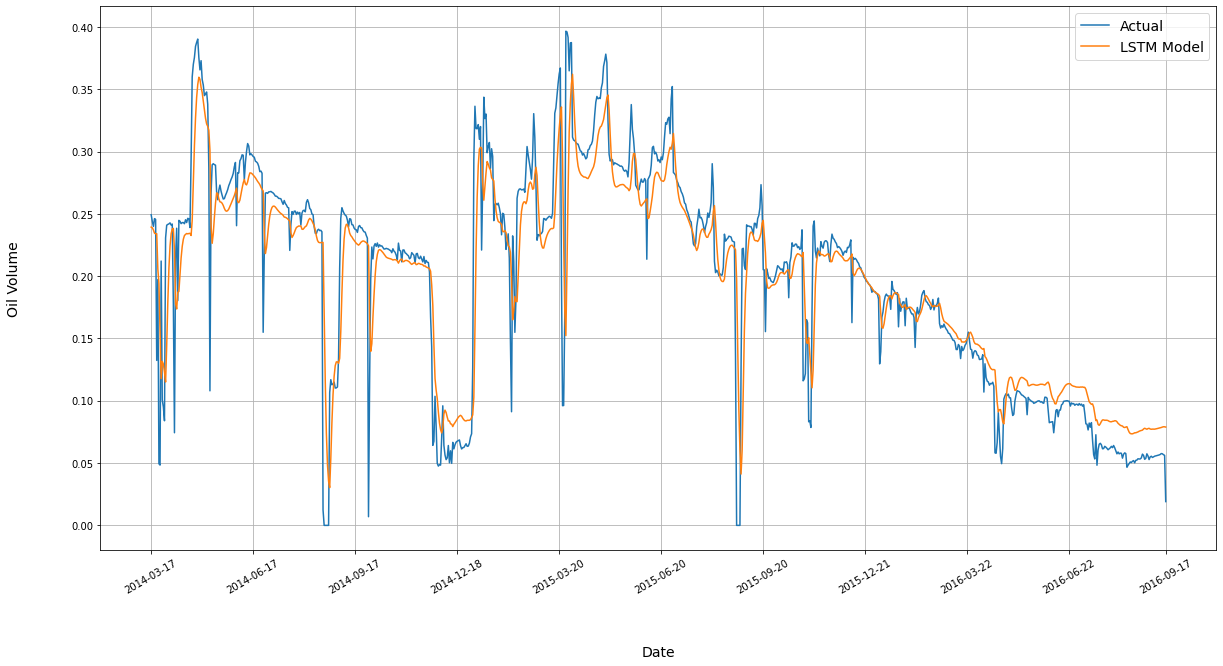

mae = 0.022381993010640144, 
mse = 0.0013430832186713815, 
rmse = 0.03664809979618836
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, None, 29)             3596      
_________________________________________________________________
lstm_1 (LSTM)                (1, None, 29)             6844      
_________________________________________________________________
dense (Dense)                (1, None, 1)              30        
Total params: 10,470
Trainable params: 10,470
Non-trainable params: 0
_________________________________________________________________
[<tf.Variable 'lstm/lstm_cell/kernel:0' shape=(1, 116) dtype=float32, numpy=
array([[ 0.09902634,  0.00278277, -0.06904209, -0.01825913, -0.1824975 ,
         0.08778441,  0.10863116,  0.17577809, -0.11728724, -0.12005468,
        -0.04544254,  0.12616247, -0.12304886,  0.04134652,  0.04780428,


In [19]:
reset_states = ResetStatesCallback()
model_checkpoint = ModelCheckpoint("lstm/LSTM_oil_checkpoint.h5", save_best_only=True)
early_stopping = EarlyStopping(patience=50)
lstm_history, lstm_model = model_lstm(callbacks=[early_stopping, model_checkpoint, reset_states], window_size=8, units=29, file_name="optimized_lstm_model")
# lstm_model = keras.models.load_model("lstm/optimized_lstm_model.h5")

plot_model_forecast(lstm_model, file_name="oil_lstm_optimized_forecast", label="LSTM")
lstm_model.summary()
print(lstm_model.trainable_variables)

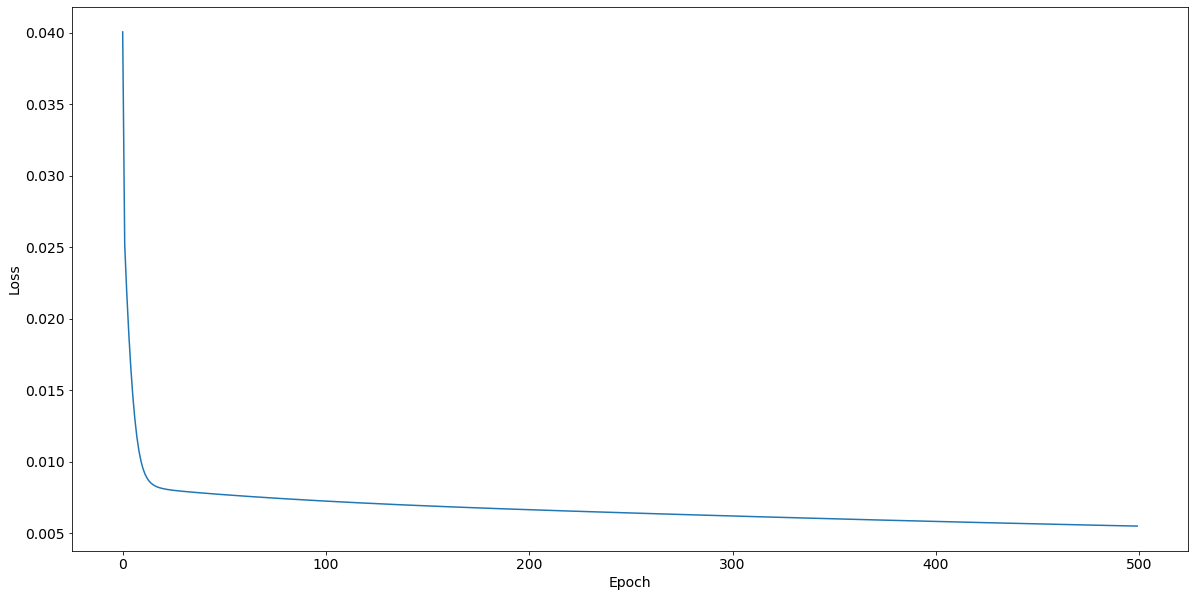

In [20]:
# Plotting the loss model
plt.figure(figsize=(20, 10))
plt.plot(lstm_history.history["loss"])
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(f'../plots/optimized_loss_model.png')
plt.show()